In [1]:
import os, csv
import shutil
import numpy as np
from imutils import paths

In [3]:
# Dont run this block since video is already split and uploaded
def copy_videos(videoPaths, folder):
    # check if the destination folder exists and if not create it
    if not os.path.exists(folder):
        os.makedirs(folder)    
    for imagePath in videoPaths: # loop over the image paths
        # grab image name and its label from the path and create a placeholder corresponding to the separate label folder
        filename = imagePath.split(os.path.sep)[-1]
        filepath = os.path.sep.join([folder, filename])
        if not os.path.exists(filepath):
            shutil.copy(imagePath, filepath)
def split_data(list_videos):
    np.random.shuffle(list_videos)
    # generate training and validation paths
    trainPathsLen = int(len(list_videos) * 0.8)
    testPathsLen = int(len(list_videos) * 0.1)
    trainPaths = list_videos[:trainPathsLen]
    testPaths = list_videos[trainPathsLen:trainPathsLen + testPathsLen]
    valPaths = list_videos[trainPathsLen + testPathsLen:]
    # copy the training and validation images to their respective directories
    copy_videos(trainPaths, 'Real_Life_Violence_Dataset/train_split')
    copy_videos(testPaths, 'Real_Life_Violence_Dataset/test_split')
    copy_videos(valPaths, 'Real_Life_Violence_Dataset/val_split')
violencePaths = list(paths.list_files('Real_Life_Violence_Dataset/Violence'))
nonviolencePaths = list(paths.list_files('Real_Life_Violence_Dataset/NonViolence'))
split_data(violencePaths)
split_data(nonviolencePaths)

In [4]:
# Also don't run this block since videos are splited and uploaded
path = "Real_Life_Violence_Dataset"
trainfiles = "train.csv"
testfiles = "test.csv"
valfiles = "val.csv"

def getPathscsv (filename, folder, path):
    list_videos = list(paths.list_files(folder))
    np.random.shuffle(list_videos)
    with open(os.path.join(path, filename), 'w') as fp:
        pass
    filepath = os.path.join(path, filename)
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["video_name", "tag"])
        for video in list_videos:
            video_name = video.split(os.path.sep)[-1]
            tag = video_name.split("_")[0]
            writer.writerow([video, tag])
getPathscsv(trainfiles, "Real_Life_Violence_Dataset/train_split", path)
getPathscsv(testfiles, "Real_Life_Violence_Dataset/test_split", path)
getPathscsv(valfiles, "Real_Life_Violence_Dataset/val_split", path)

In [5]:
!pip install -q git+https://github.com/MJAHMADEE/docs
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import imageio
import cv2
import os

In [6]:
MAX_SEQ_LENGTH = 20 # Set to pad shorter videos to this length
NUM_FEATURES = 1024
IMG_SIZE = 128 # Reduce image size to 128x128 instead of 224x224 to speed training
EPOCHS = 10

In [7]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

In [8]:
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

train_df = pd.read_csv("Real_Life_Violence_Dataset/train.csv")
test_df = pd.read_csv("Real_Life_Violence_Dataset/test.csv")
val_df = pd.read_csv("Real_Life_Violence_Dataset/val.csv")
feature_extractor = build_feature_extractor()
# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())

29084464/29084464 [==============================] - 1s 0us/step
['NV', 'V']


In [10]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path, max_frames=MAX_SEQ_LENGTH)

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [11]:
# Note: This block below may take upto a day to finish converting all videos and load into dataframes, 
# if you're testing the training, please comment out this block below, 
# download x_train.npy from https://drive.google.com/file/d/1-H1EpGGg1VAFQGaamtLlMxECVZ95UGdD/view?usp=sharing to the current directory
# and uncomment the block of code below this block to load in processed nparrays instead.
x_train, y_train = prepare_all_videos(train_df)
x_test, y_test = prepare_all_videos(test_df)
x_val, y_val = prepare_all_videos(val_df)
np.save('x_train', x_train)
np.save('x_test', x_test)
np.save('y_train', y_train)
np.save('y_test', y_test)
np.save('x_val', x_val)
np.save('y_val', y_val)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 92ms/step


In [ ]:
#x_train, y_train = np.load("x_train.npy"), np.load("y_train.npy")
#x_test, y_test = np.load("x_test.npy"), np.load("y_test.npy")
#x_val, y_val = np.load("x_val.npy"), np.load("y_val.npy")

In [12]:
print(f"Frame features in train set: {x_train.shape}")
print(f"Frame labels in train set: {y_train.shape}")
print(f"Frame features in test set: {x_test.shape}")
print(f"Frame labels in test set: {y_test.shape}")

Frame features in train set: (1600, 20, 1024)
Frame labels in train set: (1600, 1)
Frame features in test set: (200, 20, 1024)
Frame labels in test set: (200, 1)


In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [15]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        x_train,
        y_train,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [16]:
trained_model = run_experiment()

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.7294
Epoch 1: val_loss improved from inf to 0.30595, saving model to video_classifier
43/43 [==============================] - 25s 520ms/step - loss: 0.8886 - accuracy: 0.7294 - val_loss: 0.3060 - val_accuracy: 0.8542
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.4424 - accuracy: 0.8265
Epoch 2: val_loss improved from 0.30595 to 0.30406, saving model to video_classifier
43/43 [==============================] - 22s 512ms/step - loss: 0.4424 - accuracy: 0.8265 - val_loss: 0.3041 - val_accuracy: 0.9042
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8618
Epoch 3: val_loss improved from 0.30406 to 0.25089, saving model to video_classifier
43/43 [==============================] - 22s 506ms/step - loss: 0.3655 - accuracy: 0.8618 - val_loss: 0.2509 - val_accuracy: 0.8917
Epoch 4/10
43/43 [==============================] - ETA: 0s - loss: 0.2

Test video path: /content/drive/MyDrive/final_project/Real_Life_Violence_Dataset/test_split/NV_954.mp4
1/1 [==============================] - 0s 297ms/step
  NV: 61.16%
  V: 38.84%



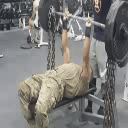

In [17]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])